# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torch_geometric': '2.0.2',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] Your Python version is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
[OK] torch 1.10.0
[OK] torch_geometric 2.0.3
[OK] numpy 1.21.5
[OK] matplotlib 3.5.1


# Chapter 18 - Graph Neural Networks for Capturing Dependencies in Graph Structured Data (Part 2/2)

- [Implementing a GNN using the PyTorch Geometric library](#Implementing-a-GNN-using-the-PyTorch-Geometric-library)
- [Other GNN layers and recent developments](#Other-GNN-layers-and-recent-developments)
  - [Spectral graph convolutions](#Spectral-graph-convolutions)
  - [Pooling](#Pooling)
  - [Normalization](#Normalization)
  - [Pointers to advanced graph neural network literature](#Pointers-to-advanced-graph-neural-network-literature)
- [Summary](#Summary)

In [2]:
from IPython.display import Image
%matplotlib inline

## Implementing a GNN using the PyTorch Geometric library

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn


from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, global_add_pool

import numpy as np

In [4]:
dset = QM9('.')
len(dset)

130831

In [5]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [6]:
data.z

tensor([6, 1, 1, 1, 1])

In [7]:
data.new_attribute = torch.tensor([1, 2, 3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

True

In [9]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features, 32),
                                  nn.ReLU(),
                                  nn.Linear(32, num_node_features*32))
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                  nn.ReLU(),
                                  nn.Linear(32, 32*16))
        self.conv1 = NNConv(num_node_features, 32, conv1_net)
        self.conv2 = NNConv(32, 16, conv2_net)
        self.fc_1 = nn.Linear(16, 32)
        self.out = nn.Linear(32, 1)
        
    def forward(self, data):
        batch, x, edge_index, edge_attr=data.batch, data.x, data.edge_index, data.edge_attr
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [10]:
from torch.utils.data import random_split


train_set, valid_set, test_set = random_split(dset,[110000, 10831, 10000])

trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
validloader = DataLoader(valid_set, batch_size=32, shuffle=True)
testloader = DataLoader(test_set, batch_size=32, shuffle=True)

In [11]:
qm9_node_feats, qm9_edge_feats = 11, 4
epochs = 4
net = ExampleNet(qm9_node_feats, qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
epochs = 4
target_idx = 1 # index position of the polarizability label

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
for total_epochs in range(epochs):
    
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output, batch.y[:, target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:, target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    
    
    print(f"Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.2f} | validation avg. loss: {val_avg_loss:.2f}")

Epochs: 0 | epoch avg. loss: 0.42 | validation avg. loss: 0.15
Epochs: 1 | epoch avg. loss: 0.14 | validation avg. loss: 0.14
Epochs: 2 | epoch avg. loss: 0.11 | validation avg. loss: 0.08
Epochs: 3 | epoch avg. loss: 0.10 | validation avg. loss: 0.19


In [14]:
net.eval()
predictions = []
real = []

for batch in testloader:
    
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:, target_idx].detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

Text(0.5, 0, 'Isotropic polarizability')

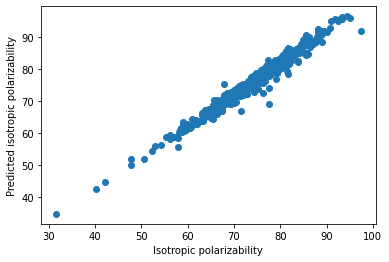

In [15]:
import matplotlib.pyplot as plt


plt.scatter(real[:500],predictions[:500])
plt.ylabel('Predicted isotropic polarizability')
plt.xlabel('Isotropic polarizability')
#plt.savefig('figures/18_12.png', dpi=300)

## Other GNN layers and recent developments

### Spectral graph convolutions

### Pooling

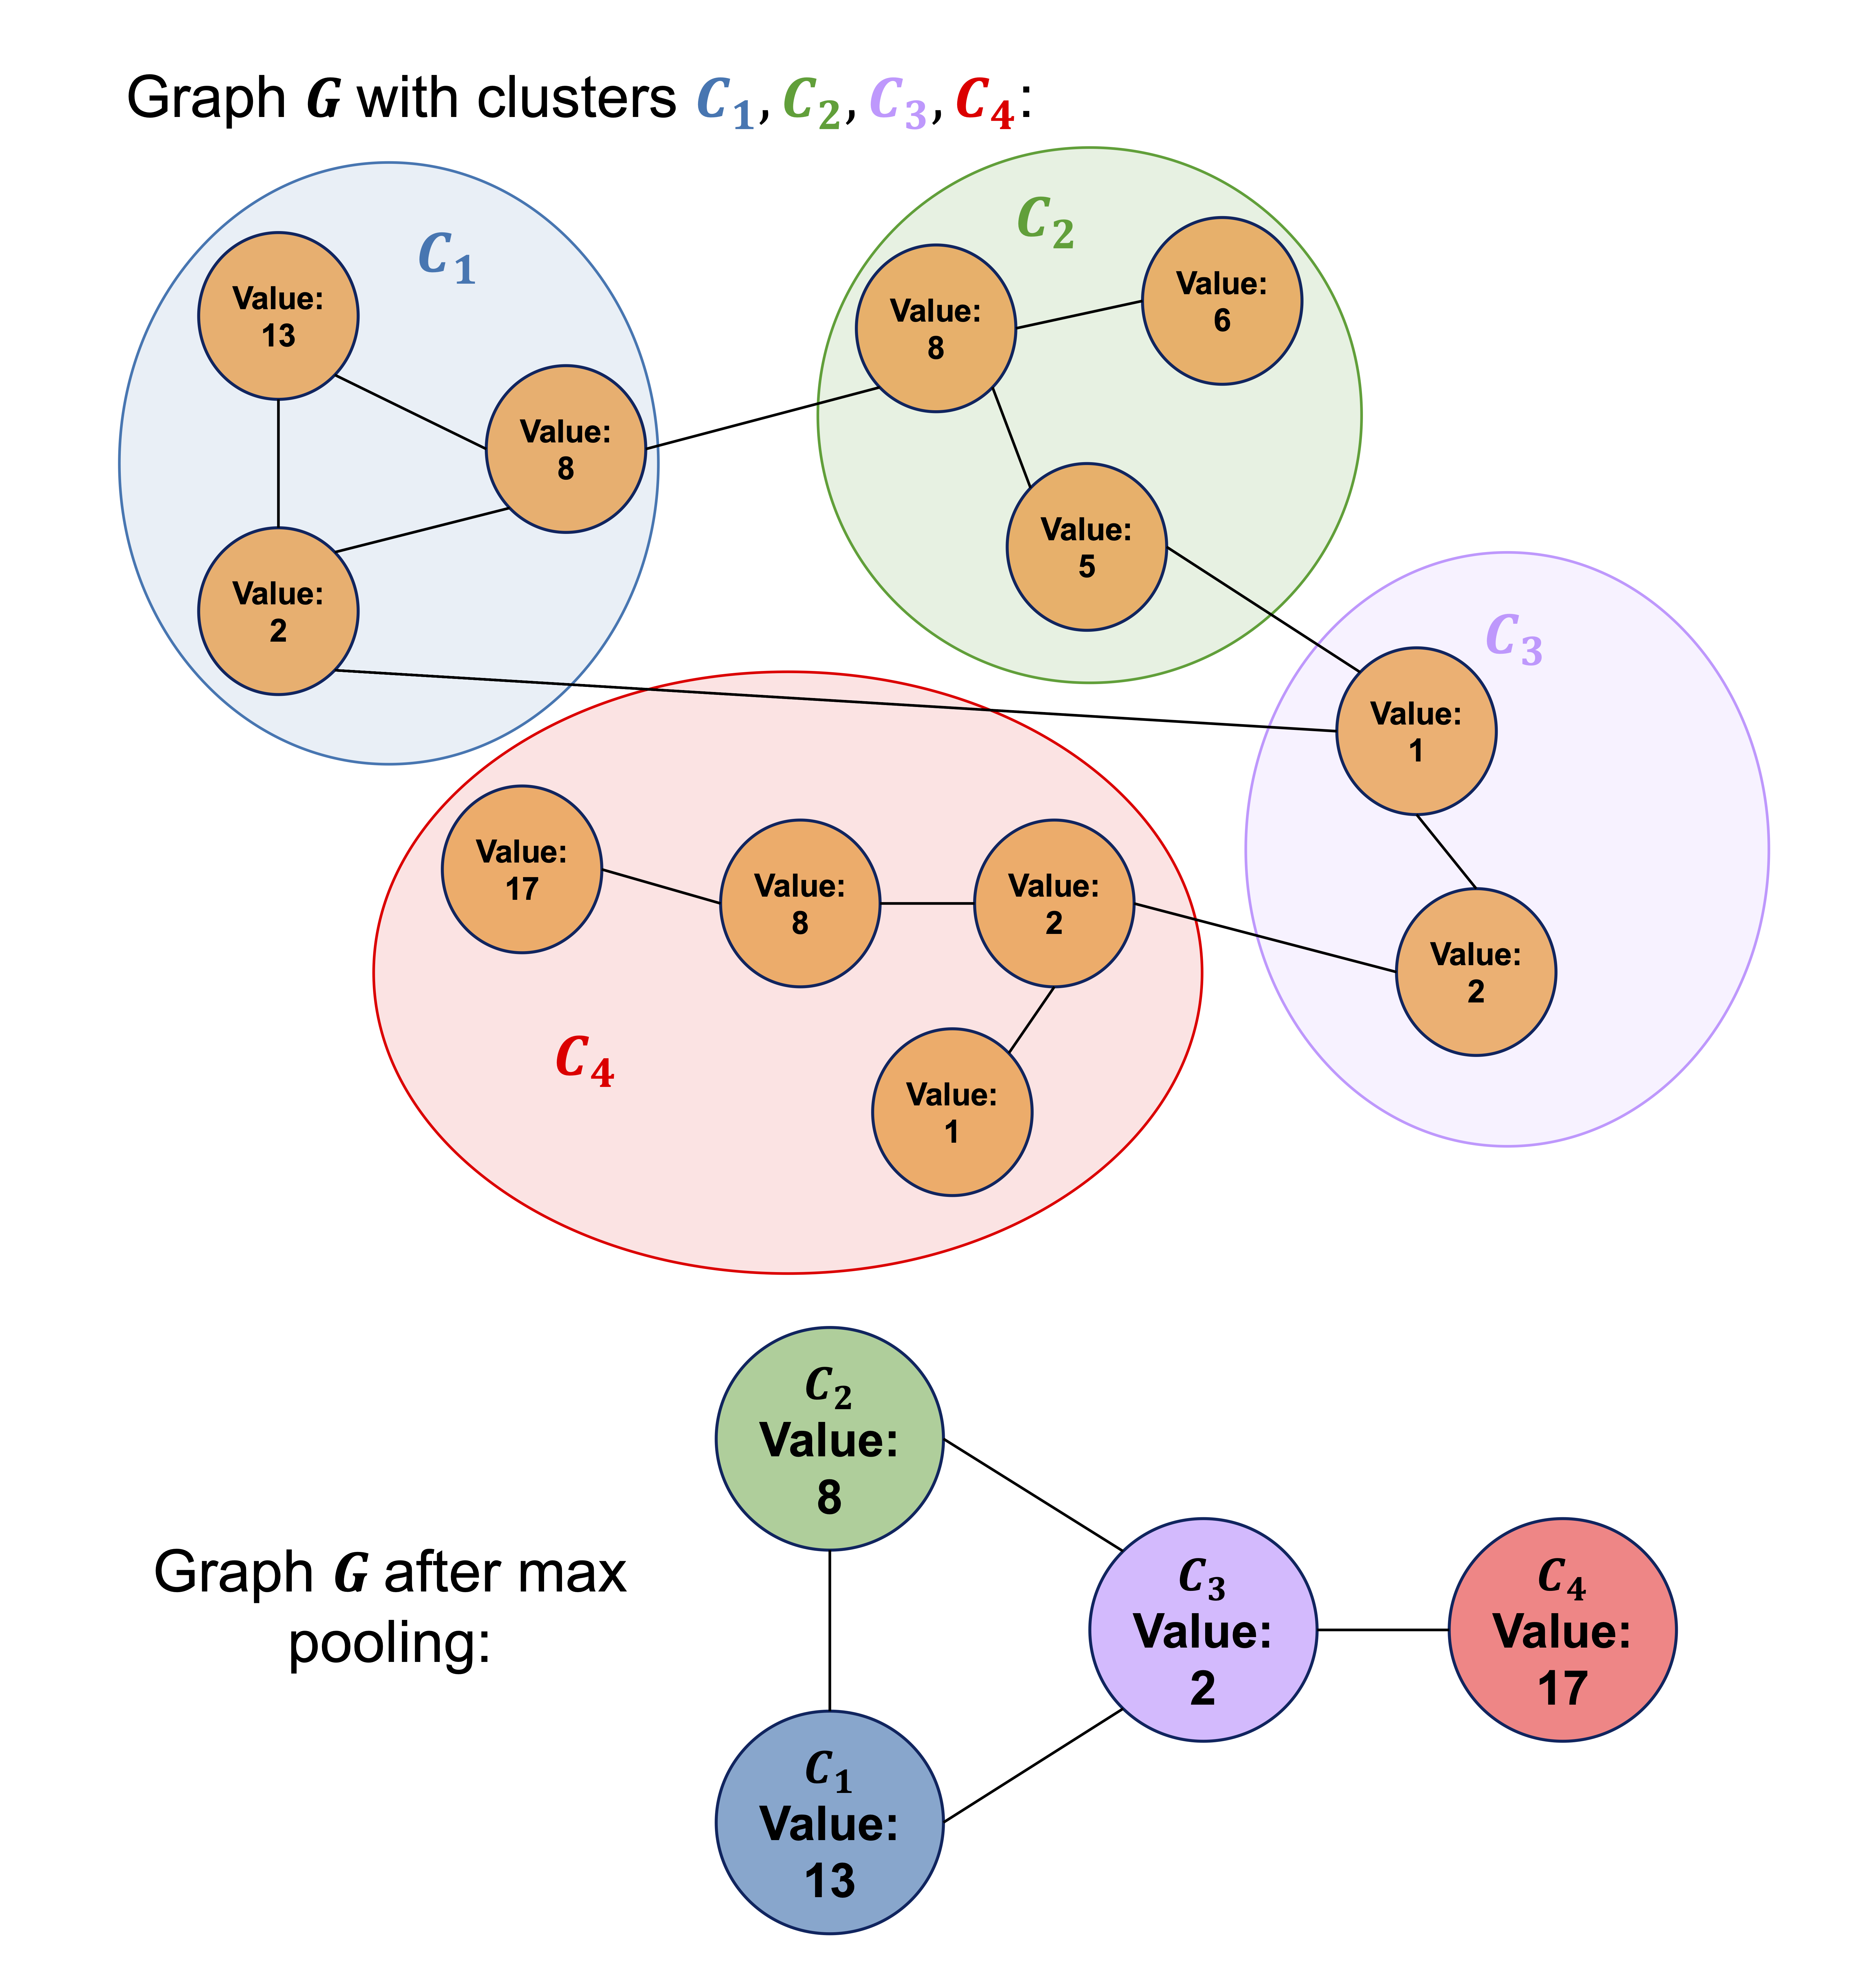

In [16]:
Image(filename='figures/18_13.png', width=600)

### Normalization

### Pointers to advanced graph neural network literature

## Summary

---

Readers may ignore the next cell.

In [1]:
! python ../.convert_notebook_to_script.py --input ch18_part2.ipynb --output ch18_part2.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch18_part2.ipynb to script
[NbConvertApp] Writing 5365 bytes to ch18_part2.py
